In [7]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from smr import File
import numpy as np
from matplotlib import pyplot as plt
from kaveh.behavioral import oculomotor
from kaveh import plots

[autoreload of kaveh.behavioral.oculomotor failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "kaveh/behavioral/oculomotor.py", line 9
    from sklearn.cluster import import KMeans
                                     ^
SyntaxError: invalid syntax
]


In [8]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Pip/P21/P21_1 LBW5 RFW5 B.smr'

smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 5)


In [10]:
chan_titles = [chan.title for chan in smr_content.channels]
for i, ct in enumerate(chan_titles):
    print("{}: {}".format(i, ct))

0: Unit
1: HEpos
2: VEpos
3: HTpos
4: VTpos
5: Keyboard


In [11]:
vt = smr_content.get_channel(4)
ve = smr_content.get_channel(2)

ht = smr_content.get_channel(3)
he = smr_content.get_channel(1)

t_range = (0,700) #s
fsize =  (20,5)
i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])


In [22]:
num_clusters = 3 # number of jump types
tt = oculomotor.target(vt.data[prange], ht.data[prange], ht.dt, 'horizontal')
target_jumps_to = tt.get_target_jumps(num_clusters)


<IPython.core.display.Javascript object>


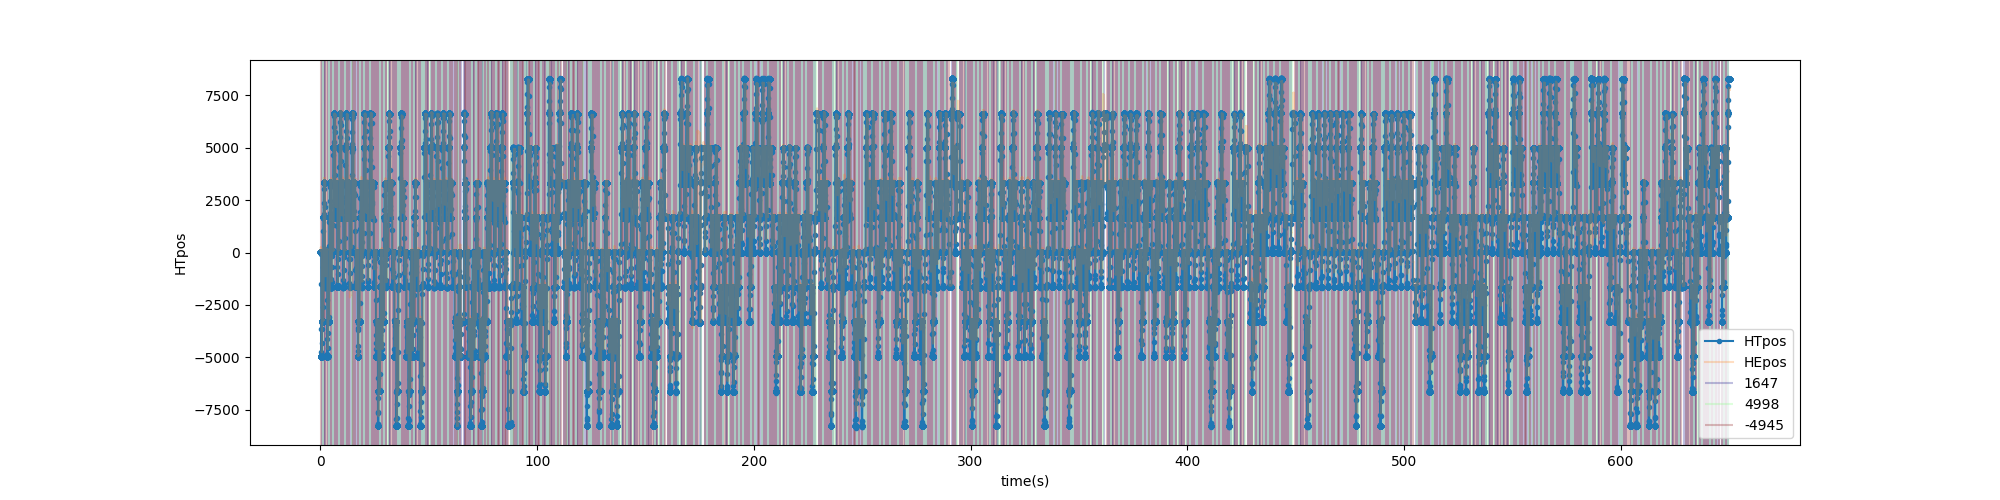

In [23]:
plt.figure(figsize = fsize)
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange]/float(2*ht.divide),'.-')
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange]/float(2*ht.divide), alpha=0.25)

plt.plot(np.arange(0, tt.ht.size)*tt.dt, tt.ht, '.-')
plt.plot(np.arange(0, he.data[prange].size)*he.dt, he.data[prange], alpha=0.25)

plt.ylabel(ht.title)
plt.xlabel('time(s)')


jump_amps = target_jumps_to.keys()
colors = plt.cm.jet(np.linspace(0, 1, len(jump_amps)))
for i, ja in enumerate(jump_amps):
    plots.axvlines(plt.gca(), target_jumps_to[ja]*tt.dt, alpha = 0.25, color=colors[i])        

legend_labels = [ht.title , he.title] + [str(ja) for ja in jump_amps]
plt.legend(legend_labels)

